# Using Groups to Create 3 Learning Models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import os



from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from scipy.optimize import curve_fit
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.metrics import r2_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

_FOLDER = "fitted_datasets_CCL/"
_FOLDER_2 = "Boosting_results/"
_FOLDER_3 = "fitted_datasets_2/"
_FOLDER_4 = "test_train_2/"
_FOLDER_5 = "Boosting_results_2/"



## Pre-processing

In [47]:
# Discover datasets and sort by sample size
dataset_files = [f for f in os.listdir(_FOLDER) if f.startswith("merged_drug_profiles_cells")]
dataset_sizes = {}
for dataset in dataset_files:
    df_temp = pd.read_csv(_FOLDER + dataset)
    dataset_sizes[dataset] = len(df_temp)


sorted_datasets = sorted(dataset_sizes.keys(), key=lambda x: dataset_sizes[x], reverse=True)

print(sorted_datasets)

['merged_drug_profiles_cells_scenario_3.15.csv.csv', 'merged_drug_profiles_cells_scenario_3.14.csv.csv', 'merged_drug_profiles_cells_scenario_3.13.csv.csv', 'merged_drug_profiles_cells_scenario_3.12.csv.csv', 'merged_drug_profiles_cells_scenario_3.11.csv.csv', 'merged_drug_profiles_cells_scenario_1.5.csv.csv', 'merged_drug_profiles_cells_scenario_3.10.csv.csv', 'merged_drug_profiles_cells_scenario_3.9.csv.csv', 'merged_drug_profiles_cells_scenario_1.4.csv.csv', 'merged_drug_profiles_cells_scenario_3.8.csv.csv', 'merged_drug_profiles_cells_scenario_3.7.csv.csv', 'merged_drug_profiles_cells_scenario_1.3.csv.csv', 'merged_drug_profiles_cells_scenario_3.6.csv.csv', 'merged_drug_profiles_cells_scenario_3.5.csv.csv', 'merged_drug_profiles_cells_scenario_3.4.csv.csv', 'merged_drug_profiles_cells_scenario_1.2.csv.csv', 'merged_drug_profiles_cells_scenario_3.3.csv.csv', 'merged_drug_profiles_cells_scenario_3.2.csv.csv', 'merged_drug_profiles_cells_scenario_3.1.csv.csv', 'merged_drug_profiles_ce

In [48]:
# Largest dataset
largest_dataset = sorted_datasets[0]  

# Smallest dataset
smallest_dataset = sorted_datasets[-1]  

# Median dataset
median_dataset_index = len(sorted_datasets) // 2
median_dataset = sorted_datasets[median_dataset_index]

largest_dataset, smallest_dataset, median_dataset

('merged_drug_profiles_cells_scenario_3.15.csv.csv',
 'merged_drug_profiles_cells_scenario_2.1.csv.csv',
 'merged_drug_profiles_cells_scenario_1.3.csv.csv')

In [46]:
df_testing = pd.read_csv(_FOLDER + f"filteredResponsesWithCCLAndParams.csv")

# Randomly select 500 samples
df_testing_sampled = df_testing.sample(n=500, random_state=42)

# Save the sampled dataset to the specified folder
df_testing_sampled.to_csv(_FOLDER_3 + "Testing.csv", index=False)


In [49]:
df_largest = pd.read_csv(f"{_FOLDER}/{largest_dataset}")
df_smallest = pd.read_csv(f"{_FOLDER}/{smallest_dataset}")
df_median = pd.read_csv(f"{_FOLDER}/{median_dataset}")
df_testing = pd.read_csv(_FOLDER_3 + f"Testing.csv")

# Extract unique identifiers from the testing dataset
testing_ids = df_testing['DRUGID_COSMICID'].unique()

# Filter out samples from the training datasets that are present in the testing dataset
df_largest_filtered = df_largest[~df_largest['DRUGID_COSMICID'].isin(testing_ids)]
df_median_filtered = df_median[~df_median['DRUGID_COSMICID'].isin(testing_ids)]
df_smallest_filtered = df_smallest[~df_smallest['DRUGID_COSMICID'].isin(testing_ids)]

# Now, ensure Group 3 does not overlap with Group 1 and 2
smallest_ids = df_smallest_filtered['DRUGID_COSMICID'].unique()
df_largest_filtered = df_largest_filtered[~df_largest_filtered['DRUGID_COSMICID'].isin(smallest_ids)]
df_median_filtered = df_median_filtered[~df_median_filtered['DRUGID_COSMICID'].isin(smallest_ids)]

# Ensure Group 2 does not contain any samples present in Group 1
median_ids = df_median_filtered['DRUGID_COSMICID'].unique()
df_largest_filtered = df_largest_filtered[~df_largest_filtered['DRUGID_COSMICID'].isin(median_ids)]

# Save the filtered datasets into new CSV files in the specified output folder
df_largest_filtered.to_csv(f"{_FOLDER_3}/Group1.csv", index=False)
df_median_filtered.to_csv(f"{_FOLDER_3}/Group2.csv", index=False)
df_smallest_filtered.to_csv(f"{_FOLDER_3}/Group3.csv", index=False)


## Coding

### Group 1

In [9]:
# Objective function for Optuna to optimize
def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

# Define parameters and labels
params = ['param_1', 'param_2', 'param_3', 'param_4']
notIncludeColumns = ['COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID', 'MAX_CONC'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

# Initialize storage for results
predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns=['DRUG_COSMICID'] + resp_labels + params)
performanceMetrics = []

# Load datasets
train_data = pd.read_csv(_FOLDER_3 + "Group1.csv")  
original_test_data = pd.read_csv(_FOLDER_3 + "Testing.csv")  

# Prepare the datasets
X_train_full = train_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_train_full = train_data[resp_labels]

# Split the training data for validation during Optuna optimization
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

# Train the model with the best hyperparameters found by Optuna
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_full, y_train_full)

# Prepare the test set and predict
X_test = original_test_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_test = original_test_data[resp_labels]

preds = best_model.predict(X_test)
predictedResults = pd.DataFrame({'DRUG_COSMICID': original_test_data['DRUGID_COSMICID'], **{label: preds[:, i] for i, label in enumerate(pred_resp_labels)}})
trueResults = original_test_data[['DRUGID_COSMICID'] + resp_labels + params]

# Compute performance metric
test_mse = mean_squared_error(y_test, preds, multioutput='raw_values')
performanceMetrics.append(test_mse)

[I 2024-03-14 18:55:46,293] A new study created in memory with name: no-name-5cabd7ed-fd8d-4d7b-b037-853bd486923a
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\3815033250.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\3815033250.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecate

In [55]:
predictedResults.to_csv(f"{_FOLDER_5}predicted_results_group1.csv", index=False)
trueResults.to_csv(f"{_FOLDER_5}true_results.csv", index=False)

### Group 2

In [57]:
# Objective function for Optuna to optimize
def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

# Define parameters and labels
params = ['param_1', 'param_2', 'param_3', 'param_4']
notIncludeColumns = ['COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID', 'MAX_CONC'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

# Initialize storage for results
predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns=['DRUG_COSMICID'] + resp_labels + params)
performanceMetrics = []

# Load datasets
train_data = pd.read_csv(_FOLDER_3 + "Group2.csv")  
original_test_data = pd.read_csv(_FOLDER_3 + "Testing.csv")  

# Prepare the datasets
X_train_full = train_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_train_full = train_data[resp_labels]

# Split the training data for validation during Optuna optimization
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

# Train the model with the best hyperparameters found by Optuna
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_full, y_train_full)

# Prepare the test set and predict
X_test = original_test_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_test = original_test_data[resp_labels]

preds = best_model.predict(X_test)
predictedResults = pd.DataFrame({'DRUG_COSMICID': original_test_data['DRUGID_COSMICID'], **{label: preds[:, i] for i, label in enumerate(pred_resp_labels)}})
trueResults = original_test_data[['DRUGID_COSMICID'] + resp_labels + params]

# Compute performance metric
test_mse = mean_squared_error(y_test, preds, multioutput='raw_values')
performanceMetrics.append(test_mse)

[I 2024-03-11 17:56:05,611] A new study created in memory with name: no-name-3eb3d342-4671-4117-abbb-b98ee0d5bce7
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\3563204975.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\3563204975.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecate

In [58]:
predictedResults.to_csv(f"{_FOLDER_5}predicted_results_group2.csv", index=False)


### Group 3

In [60]:
# Objective function for Optuna to optimize
def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

# Define parameters and labels
params = ['param_1', 'param_2', 'param_3', 'param_4']
notIncludeColumns = ['COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID', 'MAX_CONC'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

# Initialize storage for results
predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns=['DRUG_COSMICID'] + resp_labels + params)
performanceMetrics = []

# Load datasets
train_data = pd.read_csv(_FOLDER_3 + "Group3.csv")  
original_test_data = pd.read_csv(_FOLDER_3 + "Testing.csv")  

# Prepare the datasets
X_train_full = train_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_train_full = train_data[resp_labels]

# Split the training data for validation during Optuna optimization
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

# Train the model with the best hyperparameters found by Optuna
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_full, y_train_full)

# Prepare the test set and predict
X_test = original_test_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
y_test = original_test_data[resp_labels]

preds = best_model.predict(X_test)
predictedResults = pd.DataFrame({'DRUG_COSMICID': original_test_data['DRUGID_COSMICID'], **{label: preds[:, i] for i, label in enumerate(pred_resp_labels)}})
trueResults = original_test_data[['DRUGID_COSMICID'] + resp_labels + params]

# Compute performance metric
test_mse = mean_squared_error(y_test, preds, multioutput='raw_values')
performanceMetrics.append(test_mse)

[I 2024-03-11 18:02:44,990] A new study created in memory with name: no-name-e0f79154-6f18-4ddb-8aea-bf10f2cad569
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\3444272373.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\3444272373.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
C:\Users\Asad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecate

In [61]:
predictedResults.to_csv(f"{_FOLDER_5}predicted_results_group3.csv", index=False)


In [ ]:
def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0)
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    return mse

params = ['param_1', 'param_2', 'param_3', 'param_4']
notIncludeColumns = ['COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID', 'MAX_CONC', 'Drug_Name', 'molecular_formula', 'Target', 'Target_Pathway', 'elements'] + params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

# Initialize storage for results
predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels + params)
performanceMetrics = []

train_data = pd.read_csv(_FOLDER_3 + f"Group3.csv")
test_data = pd.read_csv(_FOLDER_3 + f"Testing.csv")


for drugId in train_data['DRUG_ID'].unique():
    print(f"Processing Drug ID: {drugId}")
    
    drug_data = train_data[train_data['DRUG_ID'] == drugId]
    X = drug_data.drop(columns=notIncludeColumns + conc_labels + resp_labels)
    y = drug_data[resp_labels]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)
    
    best_params = study.best_params
    best_model = xgb.XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    
    # Prepare the test data
    test_data_filtered = test_data[test_data['DRUG_ID'] == drugId]
    X_test = test_data_filtered.drop(columns=notIncludeColumns + conc_labels + resp_labels)
    y_test = test_data_filtered[resp_labels]
    
    preds = best_model.predict(X_test)
    
    # Append to your results DataFrames
    predictedResults = pd.concat([predictedResults, pd.DataFrame({'DRUG_COSMICID': test_data_filtered['DRUGID_COSMICID'], **{label: preds[:, i] for i, label in enumerate(pred_resp_labels)}})])
    trueResults = pd.concat([trueResults, test_data_filtered[['DRUGID_COSMICID'] + resp_labels + params]])
    
    test_mse = mean_squared_error(y_test, preds)
    performanceMetrics.append(test_mse)

## Analysis

### Group 1

In [1]:
def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def getOptimalParamters(drug_curves):
    conc_labels = ["fd_num_"+str(i) for i in range(10)]
    resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
    drug_curves['param_1'] = None
    drug_curves['param_2'] = None
    drug_curves['param_3'] = None
    drug_curves['param_4'] = None
    for ind in range(len(drug_curves)):
        curve = drug_curves.loc[ind]
        XData = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
        YData = curve[resp_labels].astype(float)
        function = ll4_R
        p0 = [0.4, 1.0, 1.0, 0.0]
        try:
            popt, pcov = curve_fit(function, XData, YData,p0, maxfev=6000, method='dogbox')
            drug_curves.at[ind, 'param_1'] = popt[0]
            drug_curves.at[ind, 'param_2'] = popt[1]
            drug_curves.at[ind, 'param_3'] = popt[2]
            drug_curves.at[ind, 'param_4'] = popt[3]
        except:
            print(curve)
    return drug_curves

In [3]:
predictedResults = pd.read_csv(f"{_FOLDER_5}predicted_results_group1.csv")
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,200_687819,1.0,0.959448,0.825130,0.654247,0.500331,0.366392,0.291590,0.301480,0.302454,0.284900
1,1012_753594,1.0,0.923921,0.885661,0.822699,0.702191,0.578878,0.422272,0.323501,0.280438,0.258068
2,1024_905965,1.0,0.934887,0.881824,0.798765,0.700003,0.595961,0.505122,0.413686,0.332103,0.296028
3,1149_1247871,1.0,0.920860,0.866460,0.762362,0.633879,0.531340,0.400258,0.320139,0.244964,0.208937
4,173_907280,1.0,0.943852,0.910312,0.831216,0.774240,0.691082,0.565366,0.451830,0.361681,0.320218
...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,1.0,0.964774,0.854359,0.752344,0.687235,0.574383,0.554284,0.463798,0.419754,0.379026
496,157_909262,1.0,0.932125,0.860112,0.789077,0.697562,0.602565,0.499593,0.415066,0.365376,0.320265
497,272_684055,1.0,0.925875,0.877116,0.803151,0.733357,0.611798,0.486246,0.366462,0.302429,0.277216
498,104_1330981,1.0,0.932299,0.882926,0.809986,0.702168,0.610137,0.472863,0.383673,0.305257,0.275244


In [4]:
predictedOptimal = getOptimalParamters(predictedResults)
predictedOptimal

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\U

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,200_687819,1.0,0.959448,0.825130,0.654247,0.500331,0.366392,0.291590,0.301480,0.302454,0.284900,-3.359903,0.986541,3.174704,0.247791
1,1012_753594,1.0,0.923921,0.885661,0.822699,0.702191,0.578878,0.422272,0.323501,0.280438,0.258068,-1.718647,0.955561,3.100727,0.11016
2,1024_905965,1.0,0.934887,0.881824,0.798765,0.700003,0.595961,0.505122,0.413686,0.332103,0.296028,-0.253333,0.986461,1.772634,-0.265048
3,1149_1247871,1.0,0.920860,0.866460,0.762362,0.633879,0.531340,0.400258,0.320139,0.244964,0.208937,-0.786484,0.97967,1.991984,-0.16303
4,173_907280,1.0,0.943852,0.910312,0.831216,0.774240,0.691082,0.565366,0.451830,0.361681,0.320218,0.071581,0.978623,2.002555,-0.429747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,1.0,0.964774,0.854359,0.752344,0.687235,0.574383,0.554284,0.463798,0.419754,0.379026,-0.62415,1.00614,1.555192,0.045967
496,157_909262,1.0,0.932125,0.860112,0.789077,0.697562,0.602565,0.499593,0.415066,0.365376,0.320265,-0.188476,0.988166,1.627301,-0.256412
497,272_684055,1.0,0.925875,0.877116,0.803151,0.733357,0.611798,0.486246,0.366462,0.302429,0.277216,-0.644834,0.967342,2.215198,-0.124639
498,104_1330981,1.0,0.932299,0.882926,0.809986,0.702168,0.610137,0.472863,0.383673,0.305257,0.275244,-0.626628,0.975958,2.108423,-0.129041


In [5]:
def showTestPredResponses(drugIdCosmic):
    samplePred = predictedOptimal[predictedOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predY = samplePred[params]
    predY = np.array(predY[params]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[params]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 500)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *predY), color="g", label = "Predicted")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

[-6.82660069  0.95526976  8.79701464  0.10256775]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


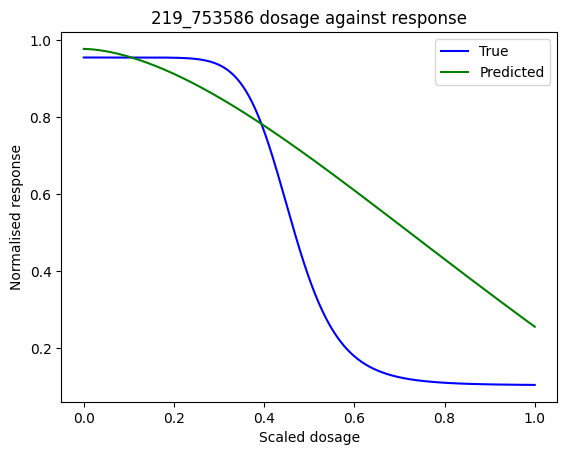

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


[-7.2495204   0.99104505  8.87286119  0.06056428]


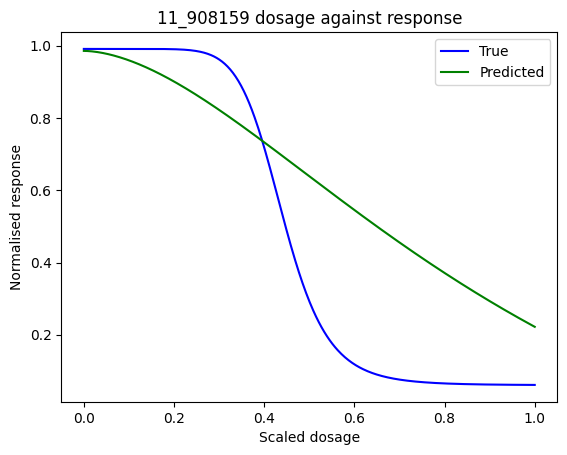

[-3.56682943e+00  9.86695177e-01  8.76086645e+00 -5.27270600e-03]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


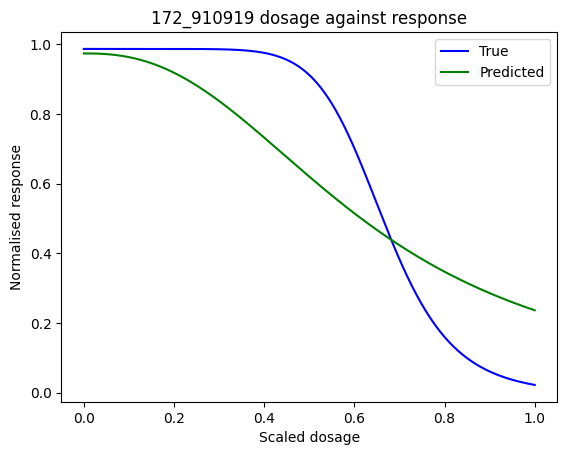

[-1.51790071  1.04049944  1.62002571 -0.09104333]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


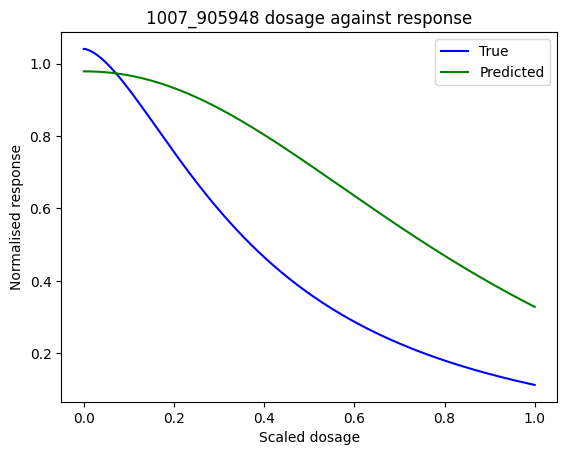

[-5.77356633  0.99286699 13.74987124 -0.01947806]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


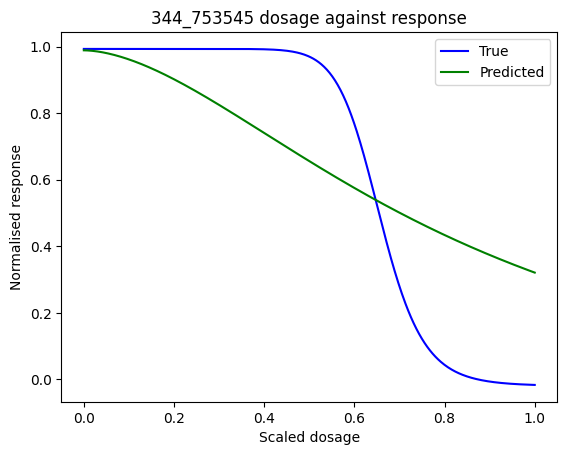

[-6.10870294e+00  1.00075329e+00  6.96672578e+00 -6.60376500e-03]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


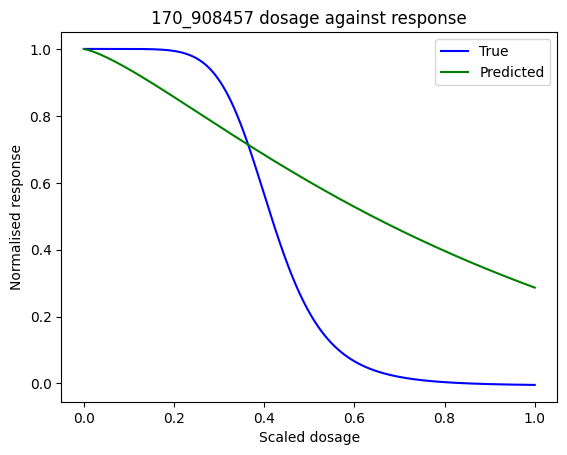

[-6.4983454   1.00987436  9.4679374   0.03754515]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


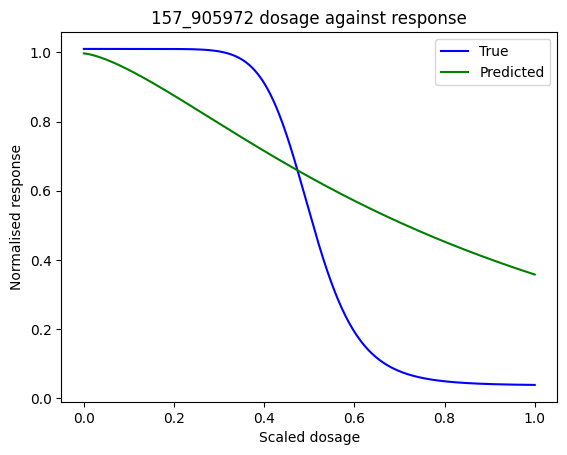

[-10.20884831   1.01352309  10.33905349   0.15748814]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


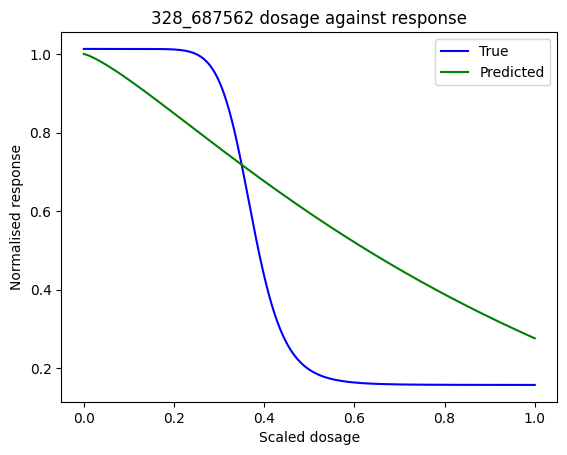

[-10.05365761   0.93254066  19.09403462   0.03214859]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\4228196396.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


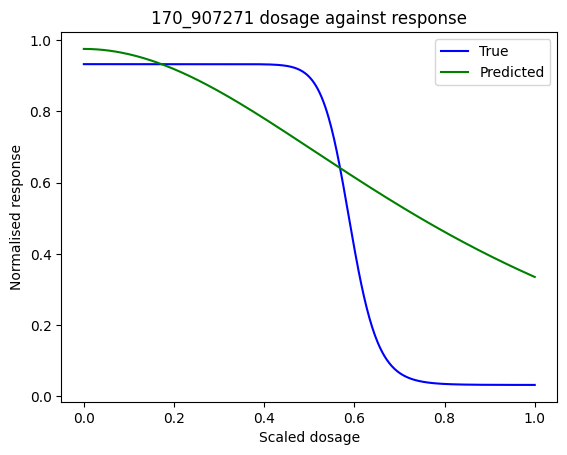

In [12]:
max_int = len(predictedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)

for index in rand_int:
    showTestPredResponses(predictedOptimal.iloc[index]['DRUG_COSMICID'])

In [17]:
# Function to calculate the logistic regression
def ll4_R(x, c, a, b, d):
    return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)

# Load the datasets
boostingTuned = predictedOptimal
trueResults = pd.read_csv(_FOLDER_5 + "true_results.csv")
params = ['param_1', 'param_2', 'param_3', 'param_4']

# Initialize a list to store R2 scores
r2_scores = []
r2_scores_with_ids = []

# Iterate over each DRUG_COSMICID in trueResults
for ind, row in trueResults.iterrows():
    cosmicId = row['DRUG_COSMICID']
    trueParams = np.array(row[params])
    predParamsRow = boostingTuned[boostingTuned['DRUG_COSMICID'] == cosmicId]
    if not predParamsRow.empty:
        predParams = np.array(predParamsRow.iloc[0][params])
        xValues = np.linspace(0.0, 1.0, 100)
        trueYcalc = ll4_R(xValues, *trueParams)
        predYcalc = ll4_R(xValues, *predParams)
        r2Score = r2_score(trueYcalc, predYcalc)
        r2_scores.append(r2Score)
        r2_scores_with_ids.append((cosmicId, r2Score))


# Calculate and print the average R2 score
average_r2_score = sum(r2_scores) / len(r2_scores) if r2_scores else 0
median_r2 = np.median(r2_scores)

df_r2_scores = pd.DataFrame(r2_scores_with_ids, columns=['DRUG_COSMICID', 'R2_Score'])



C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

In [18]:
print(f"Average R2 score for Boosting Predicted Tuned: {average_r2_score}")
print(r2_scores)
print(f"Median R²: {median_r2}")

counts = {
    '>0.9': 0,
    '0.8-0.9': 0,
    '0.7-0.8': 0,
    '0.6-0.7': 0,
    '0.5-0.6': 0,
    '0.4-0.5': 0,
    '0.3-0.4': 0,
    '0.2-0.3': 0,
    '0.1-0.2': 0,
    '0-0.1': 0,
    '<0': 0
}

# Iterate over R² scores and increment the corresponding counter
for score in r2_scores:
    if score > 0.9:
        counts['>0.9'] += 1
    elif 0.8 < score <= 0.9:
        counts['0.8-0.9'] += 1
    elif 0.7 < score <= 0.8:
        counts['0.7-0.8'] += 1
    elif 0.6 < score <= 0.7:
        counts['0.6-0.7'] += 1
    elif 0.5 < score <= 0.6:
        counts['0.5-0.6'] += 1
    elif 0.4 < score <= 0.5:
        counts['0.4-0.5'] += 1
    elif 0.3 < score <= 0.4:
        counts['0.3-0.4'] += 1
    elif 0.2 < score <= 0.3:
        counts['0.2-0.3'] += 1
    elif 0.1 < score <= 0.2:
        counts['0.1-0.2'] += 1
    elif 0 < score <= 0.1:
        counts['0-0.1'] += 1
    else:  # score < 0
        counts['<0'] += 1

# Print counts
for category, count in counts.items():
    print(f"R² {category}: {count} scores")

Average R2 score for Boosting Predicted Tuned: 0.5716946725197969
[0.7709436644196643, 0.8477716919752394, 0.6268457723988938, 0.7751728068894053, 0.7497991148141583, 0.42156414846637214, -0.25231328767431194, 0.7769390023329308, 0.597837208062433, 0.6298228240411976, 0.6604822391354928, 0.7578792117523254, 0.11749981208843352, 0.27932791287776515, 0.8447335761157235, 0.8006470886653009, -0.14636533045119493, 0.7789770415295489, 0.8859065164128351, 0.7065235871521391, -0.08733115224870436, 0.6882784064482244, 0.7980151720588373, 0.7229839952529373, 0.5706823288696716, -0.10742617139783794, 0.6031800046243889, 0.3464827797679303, 0.4923048186101546, 0.7622396044823293, 0.7813690048922015, 0.5657970302938291, 0.6029127843783048, 0.8642641060881661, 0.6223839332269722, 0.6745222446185424, 0.8806168519685361, 0.5868535689820638, 0.641491346919463, 0.528781881050725, 0.7003302829865787, 0.8319427646498954, 0.6873059894622568, 0.7973821822757119, -0.5283149161883447, 0.6300207686523742, 0.57

### Group 2

In [21]:
predictedResults = pd.read_csv(f"{_FOLDER_5}predicted_results_group2.csv")
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,200_687819,0.999391,0.945199,0.828775,0.679815,0.556186,0.466725,0.390446,0.309492,0.196872,0.160174
1,1012_753594,0.999391,0.945172,0.893474,0.821584,0.716335,0.565258,0.439248,0.300342,0.128893,0.108850
2,1024_905965,0.999391,0.945434,0.873073,0.780105,0.653361,0.506586,0.365630,0.242145,0.152021,0.123963
3,1149_1247871,0.999391,0.944529,0.873280,0.781626,0.622629,0.463668,0.303119,0.188784,0.122970,0.102839
4,173_907280,0.999391,0.943933,0.884090,0.787868,0.669597,0.557385,0.392281,0.260545,0.144960,0.106833
...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,0.999391,0.943706,0.848170,0.710871,0.558638,0.492485,0.361298,0.226954,0.160889,0.149460
496,157_909262,0.999391,0.945569,0.882038,0.783381,0.658265,0.507331,0.332601,0.220989,0.142332,0.118826
497,272_684055,0.999391,0.945295,0.872006,0.782760,0.639830,0.517772,0.374121,0.275685,0.196757,0.171532
498,104_1330981,0.999391,0.944192,0.881642,0.793965,0.628509,0.500825,0.356622,0.256075,0.152253,0.126590


In [22]:
predictedOptimal = getOptimalParamters(predictedResults)
predictedOptimal

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,200_687819,0.999391,0.945199,0.828775,0.679815,0.556186,0.466725,0.390446,0.309492,0.196872,0.160174,-0.457491,1.006551,1.532718,-0.376531
1,1012_753594,0.999391,0.945172,0.893474,0.821584,0.716335,0.565258,0.439248,0.300342,0.128893,0.108850,-0.452288,0.973333,2.390192,-0.491134
2,1024_905965,0.999391,0.945434,0.873073,0.780105,0.653361,0.506586,0.365630,0.242145,0.152021,0.123963,-1.001628,0.976914,2.384787,-0.220984
3,1149_1247871,0.999391,0.944529,0.873280,0.781626,0.622629,0.463668,0.303119,0.188784,0.122970,0.102839,-1.660786,0.969494,2.878315,-0.088768
4,173_907280,0.999391,0.943933,0.884090,0.787868,0.669597,0.557385,0.392281,0.260545,0.144960,0.106833,-0.51191,0.978316,2.203898,-0.455857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,0.999391,0.943706,0.848170,0.710871,0.558638,0.492485,0.361298,0.226954,0.160889,0.149460,-0.802539,0.994891,1.866184,-0.268274
496,157_909262,0.999391,0.945569,0.882038,0.783381,0.658265,0.507331,0.332601,0.220989,0.142332,0.118826,-1.393825,0.970462,2.75201,-0.122665
497,272_684055,0.999391,0.945295,0.872006,0.782760,0.639830,0.517772,0.374121,0.275685,0.196757,0.171532,-1.139611,0.978999,2.367308,-0.112995
498,104_1330981,0.999391,0.944192,0.881642,0.793965,0.628509,0.500825,0.356622,0.256075,0.152253,0.126590,-1.172556,0.978222,2.478274,-0.160059


[-9.69869381  0.99280649 10.69017815  0.02140314]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


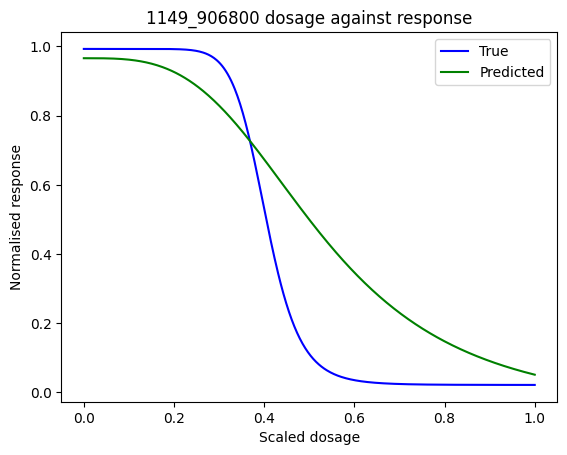

[-12.33760549   0.99428803  28.13831507   0.11800853]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


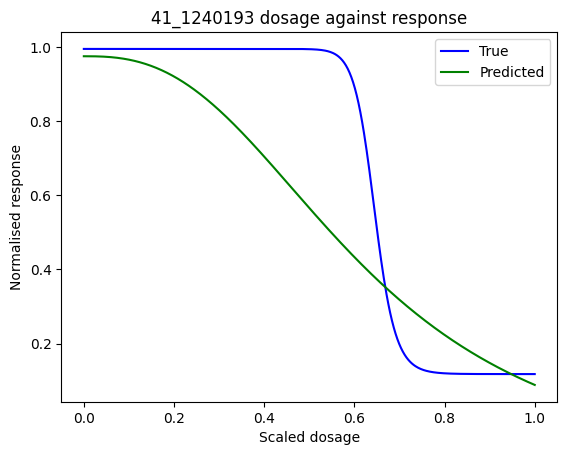

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


[-8.26241867e+01  1.00975506e+00  3.10850765e+02  3.01415200e-03]


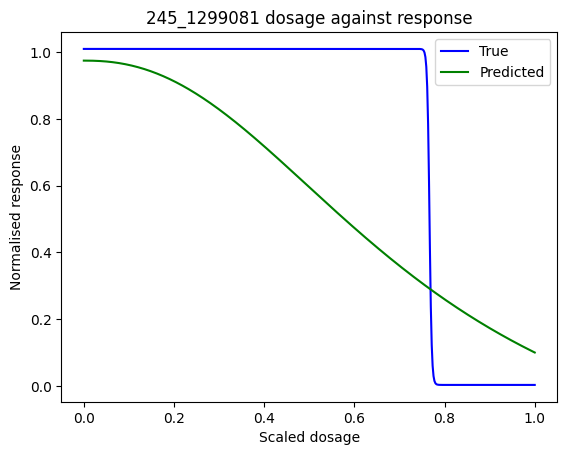

[-8.64101001  0.99931245 10.52293137  0.02665891]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


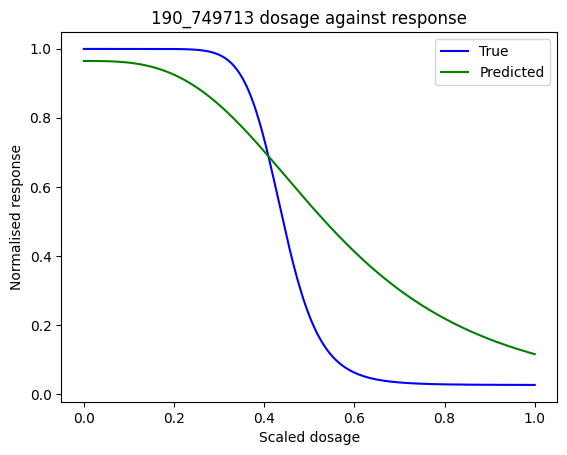

[-9.37649305  1.0126659   7.16042089  0.04911187]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


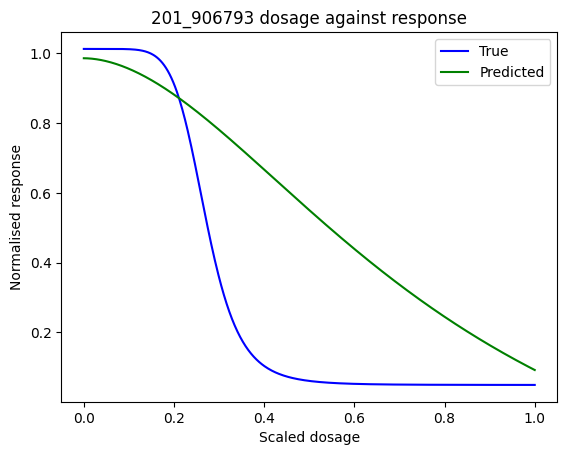

[-4.22244057  1.00996246  9.63555718  0.16295466]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


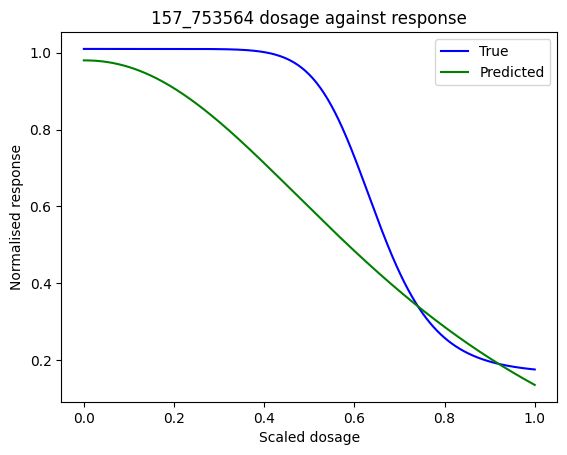

[-4.8850791   0.9817846   5.81679581  0.03772207]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


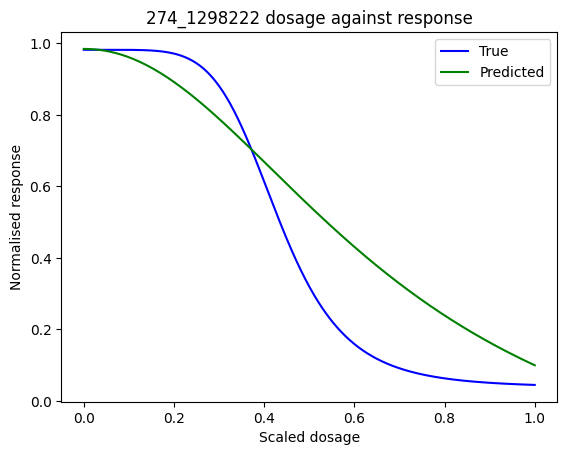

[-6.40568774  0.97629837 15.19398419 -0.01622331]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


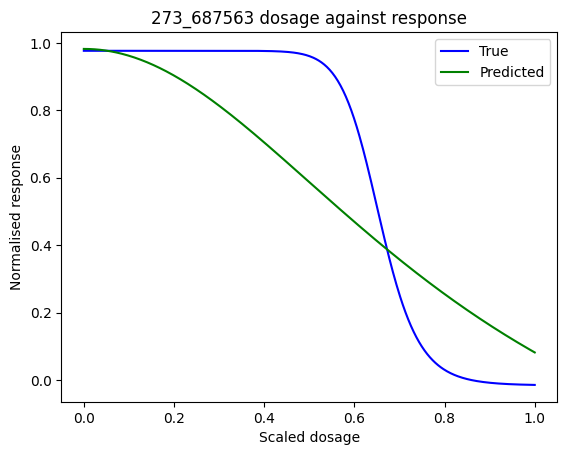

[-2.32362776  0.9376839   6.23561705 -0.08836227]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2085710770.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


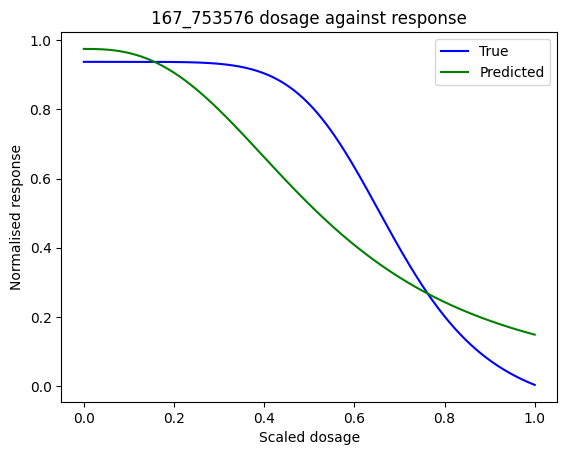

In [23]:
max_int = len(predictedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)

for index in rand_int:
    showTestPredResponses(predictedOptimal.iloc[index]['DRUG_COSMICID'])

In [24]:
# Function to calculate the logistic regression
def ll4_R(x, c, a, b, d):
    return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)

# Load the datasets
boostingTuned = predictedOptimal
trueResults = pd.read_csv(_FOLDER_5 + "true_results.csv")
params = ['param_1', 'param_2', 'param_3', 'param_4']

# Initialize a list to store R2 scores
r2_scores = []
r2_scores_with_ids = []

# Iterate over each DRUG_COSMICID in trueResults
for ind, row in trueResults.iterrows():
    cosmicId = row['DRUG_COSMICID']
    trueParams = np.array(row[params])
    predParamsRow = boostingTuned[boostingTuned['DRUG_COSMICID'] == cosmicId]
    if not predParamsRow.empty:
        predParams = np.array(predParamsRow.iloc[0][params])
        xValues = np.linspace(0.0, 1.0, 100)
        trueYcalc = ll4_R(xValues, *trueParams)
        predYcalc = ll4_R(xValues, *predParams)
        r2Score = r2_score(trueYcalc, predYcalc)
        r2_scores.append(r2Score)
        r2_scores_with_ids.append((cosmicId, r2Score))


# Calculate and print the average R2 score
average_r2_score = sum(r2_scores) / len(r2_scores) if r2_scores else 0
median_r2 = np.median(r2_scores)

df_r2_scores = pd.DataFrame(r2_scores_with_ids, columns=['DRUG_COSMICID', 'R2_Score'])

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

In [25]:
print(f"Average R2 score for Boosting Predicted Tuned: {average_r2_score}")
print(r2_scores)
print(f"Median R²: {median_r2}")

counts = {
    '>0.9': 0,
    '0.8-0.9': 0,
    '0.7-0.8': 0,
    '0.6-0.7': 0,
    '0.5-0.6': 0,
    '0.4-0.5': 0,
    '0.3-0.4': 0,
    '0.2-0.3': 0,
    '0.1-0.2': 0,
    '0-0.1': 0,
    '<0': 0
}

# Iterate over R² scores and increment the corresponding counter
for score in r2_scores:
    if score > 0.9:
        counts['>0.9'] += 1
    elif 0.8 < score <= 0.9:
        counts['0.8-0.9'] += 1
    elif 0.7 < score <= 0.8:
        counts['0.7-0.8'] += 1
    elif 0.6 < score <= 0.7:
        counts['0.6-0.7'] += 1
    elif 0.5 < score <= 0.6:
        counts['0.5-0.6'] += 1
    elif 0.4 < score <= 0.5:
        counts['0.4-0.5'] += 1
    elif 0.3 < score <= 0.4:
        counts['0.3-0.4'] += 1
    elif 0.2 < score <= 0.3:
        counts['0.2-0.3'] += 1
    elif 0.1 < score <= 0.2:
        counts['0.1-0.2'] += 1
    elif 0 < score <= 0.1:
        counts['0-0.1'] += 1
    else:  # score < 0
        counts['<0'] += 1

# Print counts
for category, count in counts.items():
    print(f"R² {category}: {count} scores")

Average R2 score for Boosting Predicted Tuned: 0.6703409857987545
[0.8155789685387392, 0.9154216631938219, 0.8851618516338328, 0.8437833058779215, 0.7661711670175766, 0.2333023999624091, 0.1910236047306939, 0.7939062144729314, 0.8145677696485811, 0.7292360186857769, 0.8320563051157641, 0.9116771102018857, 0.39505551750282675, 0.8892937452862557, 0.8606159360956632, 0.953271365188472, 0.19992965644231542, 0.8820000229732288, 0.782515549153843, 0.6973705599430295, 0.290290344936609, 0.6796399910659142, 0.762855481269291, 0.7419519974503229, 0.9545512726426434, 0.4274103134767958, 0.7227480530212356, 0.18978331946793914, 0.6868829555035854, 0.8461533595119155, 0.8344539251588298, 0.8156133411916557, 0.7974926746724765, 0.4659389455824108, 0.3829649778569506, 0.917171010703034, 0.9992137752599126, 0.8826169604661624, 0.5963070126784162, 0.48549267358961035, 0.6435003032223177, 0.7777653722657117, 0.7783011788430764, 0.9248577251282435, 0.18941663594255698, 0.62715517062086, 0.9225432575167

### Group 3

In [26]:
predictedResults = pd.read_csv(f"{_FOLDER_5}predicted_results_group3.csv")
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,200_687819,1.0,0.985926,0.876054,0.886747,0.574881,0.427233,0.274247,0.267651,0.278657,0.256454
1,1012_753594,1.0,0.977979,0.926922,0.842757,0.683329,0.487992,0.313650,0.242661,0.136946,0.116408
2,1024_905965,1.0,0.973161,0.895543,0.783349,0.642093,0.480056,0.329137,0.195716,0.125543,0.106077
3,1149_1247871,1.0,0.976055,0.897633,0.778949,0.606586,0.422787,0.274354,0.114342,0.089761,0.093855
4,173_907280,1.0,0.973746,0.910759,0.824033,0.711856,0.580655,0.440784,0.252319,0.196013,0.170417
...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,1.0,0.970284,0.880816,0.685374,0.538785,0.374549,0.290487,0.258681,0.225981,0.185325
496,157_909262,1.0,0.982020,0.910438,0.806898,0.666508,0.487281,0.299421,0.175258,0.120186,0.096185
497,272_684055,1.0,0.971848,0.900077,0.787785,0.571071,0.420646,0.267882,0.134439,0.113552,0.102053
498,104_1330981,1.0,0.970747,0.887930,0.786879,0.686047,0.525423,0.344118,0.277688,0.277285,0.256009


In [27]:
predictedOptimal = getOptimalParamters(predictedResults)
predictedOptimal

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,200_687819,1.0,0.985926,0.876054,0.886747,0.574881,0.427233,0.274247,0.267651,0.278657,0.256454,-4.973512,0.96443,6.078873,0.251815
1,1012_753594,1.0,0.977979,0.926922,0.842757,0.683329,0.487992,0.313650,0.242661,0.136946,0.116408,-2.130982,0.983423,3.571428,0.003267
2,1024_905965,1.0,0.973161,0.895543,0.783349,0.642093,0.480056,0.329137,0.195716,0.125543,0.106077,-1.51378,0.985789,2.774989,-0.117398
3,1149_1247871,1.0,0.976055,0.897633,0.778949,0.606586,0.422787,0.274354,0.114342,0.089761,0.093855,-2.172356,0.981373,3.300163,-0.047346
4,173_907280,1.0,0.973746,0.910759,0.824033,0.711856,0.580655,0.440784,0.252319,0.196013,0.170417,-1.203873,0.981006,2.823071,-0.111069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,1.0,0.970284,0.880816,0.685374,0.538785,0.374549,0.290487,0.258681,0.225981,0.185325,-2.61399,0.994795,2.955678,0.134457
496,157_909262,1.0,0.982020,0.910438,0.806898,0.666508,0.487281,0.299421,0.175258,0.120186,0.096185,-1.94234,0.981889,3.321227,-0.056255
497,272_684055,1.0,0.971848,0.900077,0.787785,0.571071,0.420646,0.267882,0.134439,0.113552,0.102053,-2.322073,0.983108,3.337909,-0.009835
498,104_1330981,1.0,0.970747,0.887930,0.786879,0.686047,0.525423,0.344118,0.277688,0.277285,0.256009,-2.256572,0.97398,3.293837,0.153736


[-2.82624052  1.02450688  6.62013055 -0.1026439 ]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


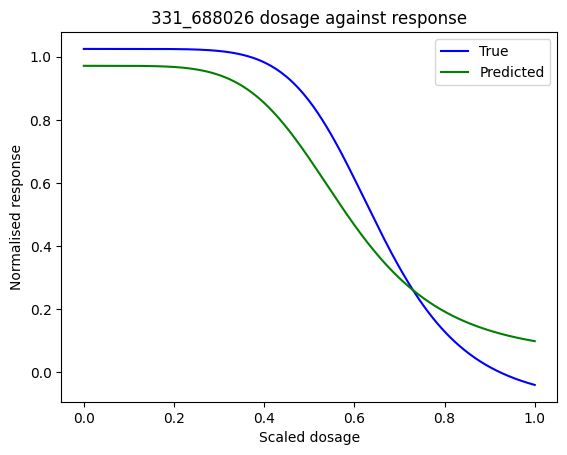

[-1.53744013e+02  9.05394153e-01  1.91568910e+02  4.01252970e-02]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


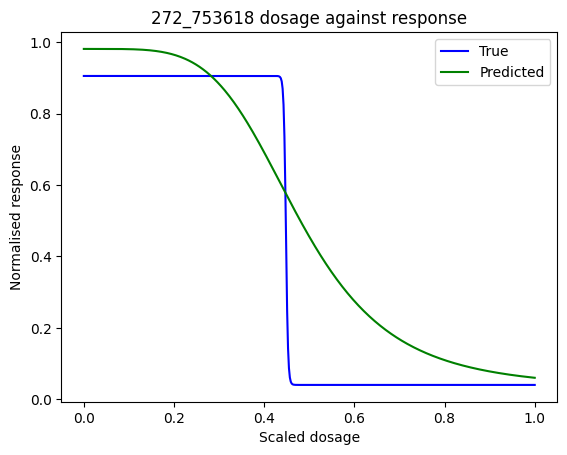

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


[-1.31990504  1.0180067   2.81145585 -0.25762962]


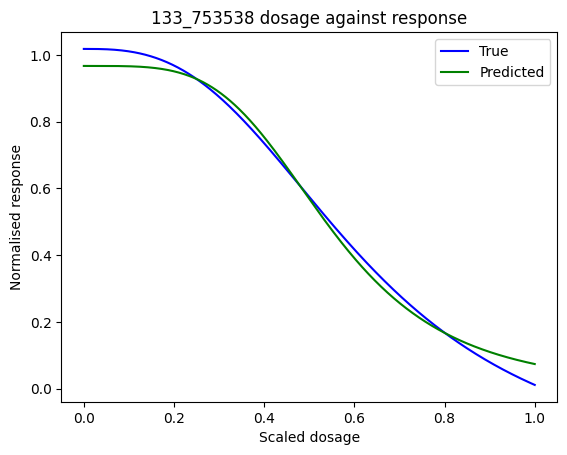

[-1.70396001  1.00939978  2.5888499  -0.20109634]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


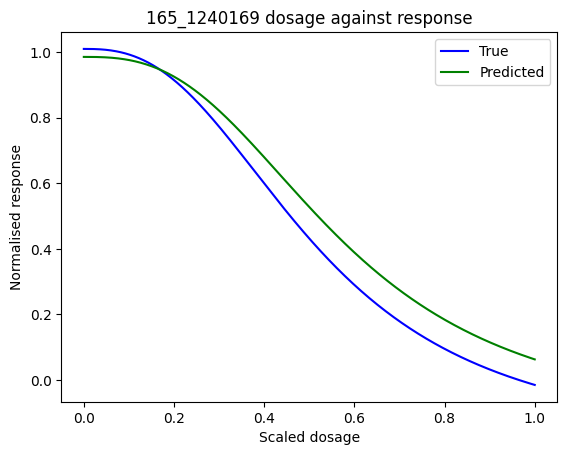

[-4.30726048  0.97446202  8.25849435 -0.03346161]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


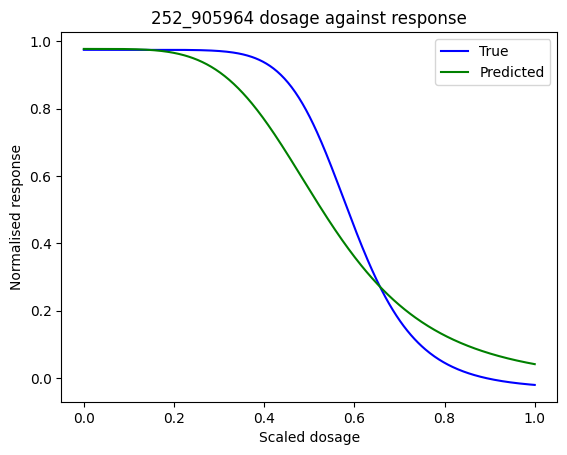

[-1.90461323  0.99450825  6.2851832  -0.18651069]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


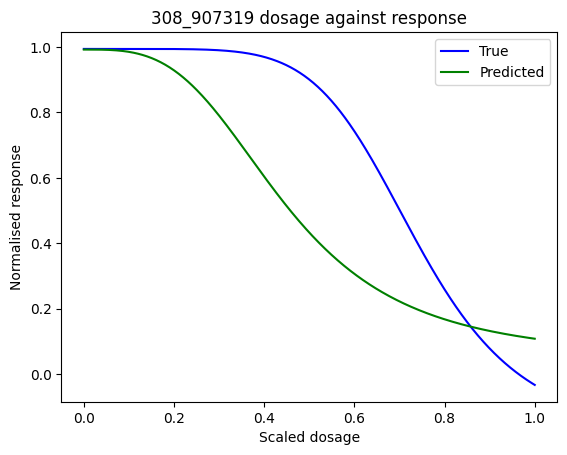

[-1.24830212e+01  9.52261437e-01  3.73803381e+01  1.00852500e-02]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


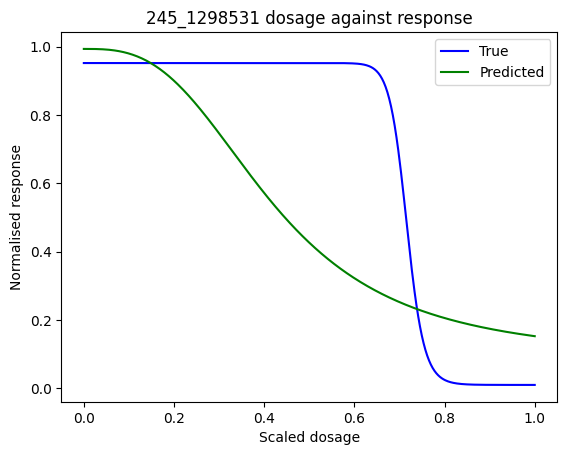

[-2.82624052  1.02450688  6.62013055 -0.1026439 ]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


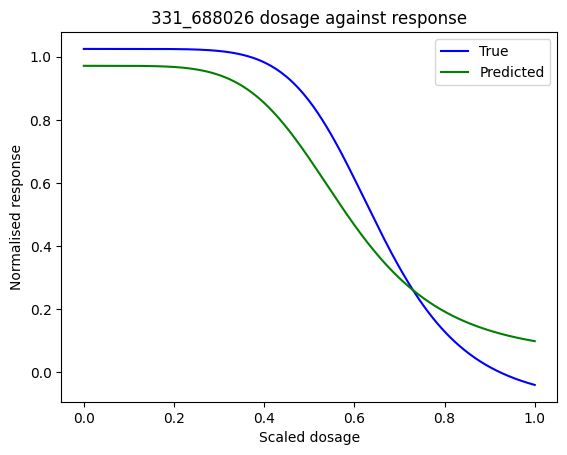

[-4.21131182  1.02339258  7.95043803  0.13994979]


C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


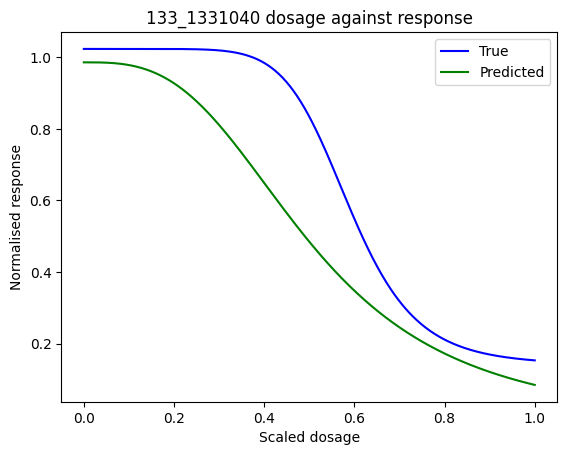

In [28]:
max_int = len(predictedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)

for index in rand_int:
    showTestPredResponses(predictedOptimal.iloc[index]['DRUG_COSMICID'])

In [29]:
# Function to calculate the logistic regression
def ll4_R(x, c, a, b, d):
    return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)

# Load the datasets
boostingTuned = predictedOptimal
trueResults = pd.read_csv(_FOLDER_5 + "true_results.csv")
params = ['param_1', 'param_2', 'param_3', 'param_4']

# Initialize a list to store R2 scores
r2_scores = []
r2_scores_with_ids = []

# Iterate over each DRUG_COSMICID in trueResults
for ind, row in trueResults.iterrows():
    cosmicId = row['DRUG_COSMICID']
    trueParams = np.array(row[params])
    predParamsRow = boostingTuned[boostingTuned['DRUG_COSMICID'] == cosmicId]
    if not predParamsRow.empty:
        predParams = np.array(predParamsRow.iloc[0][params])
        xValues = np.linspace(0.0, 1.0, 100)
        trueYcalc = ll4_R(xValues, *trueParams)
        predYcalc = ll4_R(xValues, *predParams)
        r2Score = r2_score(trueYcalc, predYcalc)
        r2_scores.append(r2Score)
        r2_scores_with_ids.append((cosmicId, r2Score))


# Calculate and print the average R2 score
average_r2_score = sum(r2_scores) / len(r2_scores) if r2_scores else 0
median_r2 = np.median(r2_scores)

df_r2_scores = pd.DataFrame(r2_scores_with_ids, columns=['DRUG_COSMICID', 'R2_Score'])

C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_11976\2190912451.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

In [30]:
print(f"Average R2 score for Boosting Predicted Tuned: {average_r2_score}")
print(r2_scores)
print(f"Median R²: {median_r2}")

counts = {
    '>0.9': 0,
    '0.8-0.9': 0,
    '0.7-0.8': 0,
    '0.6-0.7': 0,
    '0.5-0.6': 0,
    '0.4-0.5': 0,
    '0.3-0.4': 0,
    '0.2-0.3': 0,
    '0.1-0.2': 0,
    '0-0.1': 0,
    '<0': 0
}

# Iterate over R² scores and increment the corresponding counter
for score in r2_scores:
    if score > 0.9:
        counts['>0.9'] += 1
    elif 0.8 < score <= 0.9:
        counts['0.8-0.9'] += 1
    elif 0.7 < score <= 0.8:
        counts['0.7-0.8'] += 1
    elif 0.6 < score <= 0.7:
        counts['0.6-0.7'] += 1
    elif 0.5 < score <= 0.6:
        counts['0.5-0.6'] += 1
    elif 0.4 < score <= 0.5:
        counts['0.4-0.5'] += 1
    elif 0.3 < score <= 0.4:
        counts['0.3-0.4'] += 1
    elif 0.2 < score <= 0.3:
        counts['0.2-0.3'] += 1
    elif 0.1 < score <= 0.2:
        counts['0.1-0.2'] += 1
    elif 0 < score <= 0.1:
        counts['0-0.1'] += 1
    else:  # score < 0
        counts['<0'] += 1

# Print counts
for category, count in counts.items():
    print(f"R² {category}: {count} scores")

Average R2 score for Boosting Predicted Tuned: 0.6571644435722876
[0.8931673120066865, 0.926442548541604, 0.9238843229801211, 0.8496256706607688, 0.8062251849751267, 0.329699138688444, -0.8944689304266902, 0.7247999686496884, 0.9114132748432962, 0.8191882598701027, 0.9829952381671476, 0.8462477149039567, 0.3373371187222922, 0.9177809811953874, 0.6699554178241481, 0.8117676702383935, 0.028305125999501524, 0.8735560777956917, 0.7173494564951519, 0.714534629452283, -0.05051464762717739, 0.5536501843131849, 0.8461727501042718, 0.7873535337850914, 0.9539871537437801, 0.539985017471319, 0.8107704113439389, 0.20479930632886334, 0.7211276581831846, 0.8963250854573537, 0.7782024902611795, 0.8256415580341281, 0.8421246775377326, 0.8034293176590702, -0.5327161605795705, 0.9039104519614488, 0.9778729083951598, 0.6070580794201459, 0.6860872637931832, -0.05071315949527122, 0.6034936381193886, 0.7255294454667678, 0.838320062699578, 0.8916792985311539, -0.12569889254724642, 0.6099751847597519, 0.93704

### Average 

In [62]:
# Load the predicted results from each group
predicted_group1 = pd.read_csv(f"{_FOLDER_5}predicted_results_group1.csv")
predicted_group2 = pd.read_csv(f"{_FOLDER_5}predicted_results_group2.csv")
predicted_group3 = pd.read_csv(f"{_FOLDER_5}predicted_results_group3.csv")

# Cast the 'DRUG_COSMICID' column to string to ensure proper merging
predicted_group1['DRUG_COSMICID'] = predicted_group1['DRUG_COSMICID'].astype(str)
predicted_group2['DRUG_COSMICID'] = predicted_group2['DRUG_COSMICID'].astype(str)
predicted_group3['DRUG_COSMICID'] = predicted_group3['DRUG_COSMICID'].astype(str)

# Merge the three groups on 'DRUG_COSMICID'
merged = predicted_group1.merge(predicted_group2, on='DRUG_COSMICID', suffixes=('_1', '_2'))
merged = merged.merge(predicted_group3, on='DRUG_COSMICID')

# Identify the prediction columns, assuming they have a common prefix like 'pred_norm_cells_'
pred_columns = [col for col in predicted_group1.columns if col.startswith('pred_norm_cells_')]

# Calculate the average for each prediction column and assign it back to the original column name
for col in pred_columns:
    merged[col] = merged[[col, f'{col}_1', f'{col}_2']].mean(axis=1)

# Drop the extra columns from merging
merged.drop(columns=[f'{col}_1' for col in pred_columns] + [f'{col}_2' for col in pred_columns], inplace=True)

# Save the averaged predictions to a new CSV file
merged.to_csv(f"{_FOLDER_5}predicted_results.csv", index=False)

In [64]:
predictedResults = pd.read_csv(f"{_FOLDER_5}predicted_results.csv")
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,200_687819,0.999797,0.963524,0.843320,0.740270,0.543799,0.420117,0.318761,0.292874,0.259327,0.233843
1,1012_753594,0.999797,0.949024,0.902019,0.829013,0.700618,0.544043,0.391723,0.288834,0.182092,0.161109
2,1024_905965,0.999797,0.951160,0.883480,0.787406,0.665152,0.527534,0.399963,0.283849,0.203222,0.175356
3,1149_1247871,0.999797,0.947148,0.879124,0.774312,0.621031,0.472598,0.325910,0.207755,0.152565,0.135210
4,173_907280,0.999797,0.953844,0.901720,0.814372,0.718564,0.609707,0.466144,0.321565,0.234218,0.199156
...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,0.999797,0.959588,0.861115,0.716196,0.594886,0.480472,0.402023,0.316478,0.268874,0.237937
496,157_909262,0.999797,0.953238,0.884196,0.793119,0.674112,0.532392,0.377205,0.270438,0.209298,0.178425
497,272_684055,0.999797,0.947673,0.883066,0.791232,0.648086,0.516738,0.376083,0.258862,0.204246,0.183600
498,104_1330981,0.999797,0.949079,0.884166,0.796943,0.672242,0.545462,0.391201,0.305812,0.244931,0.219281


In [65]:
predictedOptimal = getOptimalParamters(predictedResults)
predictedOptimal

C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\1560763125.py:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
C:\U

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,200_687819,0.999797,0.963524,0.843320,0.740270,0.543799,0.420117,0.318761,0.292874,0.259327,0.233843,-2.45731,0.98562,2.854841,0.164917
1,1012_753594,0.999797,0.949024,0.902019,0.829013,0.700618,0.544043,0.391723,0.288834,0.182092,0.161109,-1.434168,0.970927,2.968757,-0.055083
2,1024_905965,0.999797,0.951160,0.883480,0.787406,0.665152,0.527534,0.399963,0.283849,0.203222,0.175356,-1.035079,0.981491,2.361046,-0.138298
3,1149_1247871,0.999797,0.947148,0.879124,0.774312,0.621031,0.472598,0.325910,0.207755,0.152565,0.135210,-1.634689,0.974506,2.770515,-0.056446
4,173_907280,0.999797,0.953844,0.901720,0.814372,0.718564,0.609707,0.466144,0.321565,0.234218,0.199156,-0.651834,0.978461,2.36921,-0.24441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,173_1240153,0.999797,0.959588,0.861115,0.716196,0.594886,0.480472,0.402023,0.316478,0.268874,0.237937,-1.388802,0.999262,2.083572,0.041547
496,157_909262,0.999797,0.953238,0.884196,0.793119,0.674112,0.532392,0.377205,0.270438,0.209298,0.178425,-1.349933,0.975974,2.647323,-0.053081
497,272_684055,0.999797,0.947673,0.883066,0.791232,0.648086,0.516738,0.376083,0.258862,0.204246,0.183600,-1.469873,0.975329,2.669357,-0.02561
498,104_1330981,0.999797,0.949079,0.884166,0.796943,0.672242,0.545462,0.391201,0.305812,0.244931,0.219281,-1.417568,0.97548,2.630467,0.013208


In [66]:
predictedOptimal.to_csv(_FOLDER_5 +'boostingPredictedTuned.csv', index=False)

In [75]:
def showTestPredResponses(drugIdCosmic):
    samplePred = predictedOptimal[predictedOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predY = samplePred[params]
    predY = np.array(predY[params]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[params]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 500)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *predY), color="g", label = "Predicted")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

[-3.47316458  0.98640516  3.67520764  0.0654166 ]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


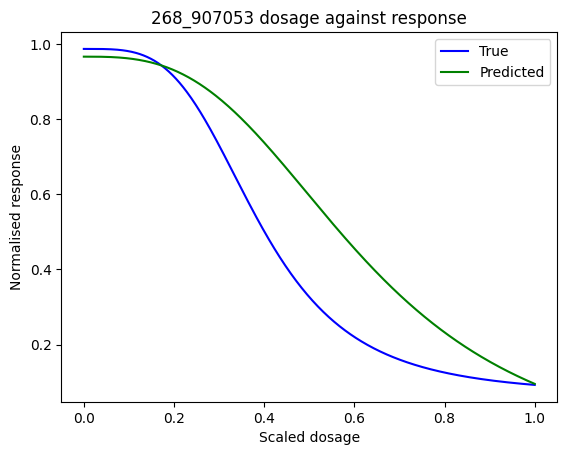

[-5.59520339e+00  1.01983092e+00  1.37011698e+01  6.74224200e-03]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


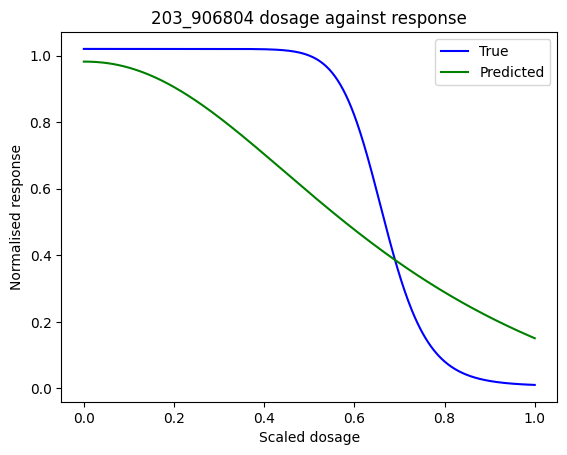

C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


[-5.00490039  0.99142781  9.18239248  0.01423386]


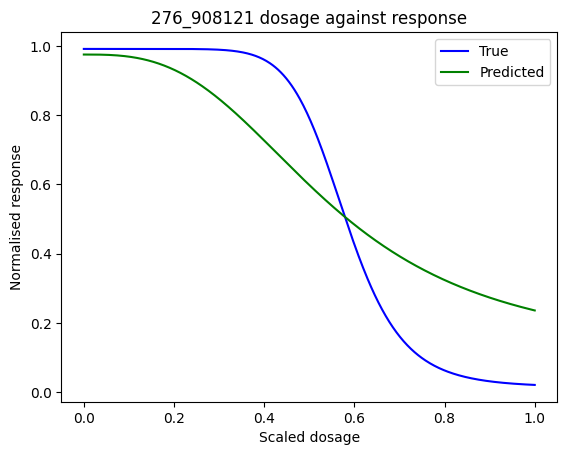

[-1.60974290e+01  9.59776519e-01  4.44756902e+01  6.15286400e-03]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


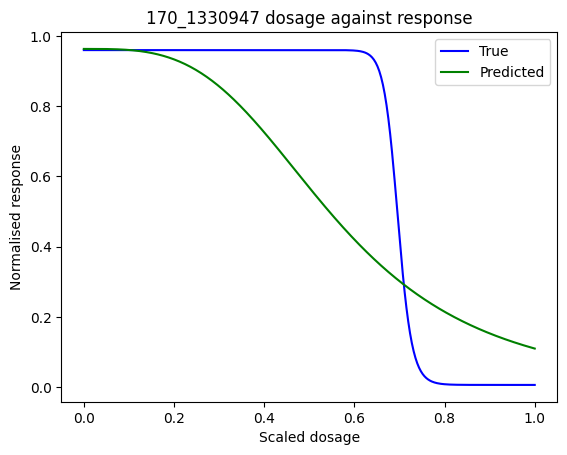

[-5.92634711e+01  9.46905036e-01  2.40715482e+02  1.95429250e-02]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


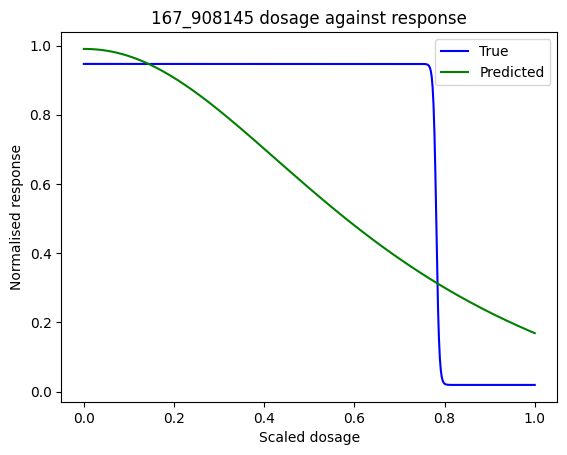

[-1.32401858e+01  1.04554192e+00  3.37047993e+01  3.20277030e-02]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


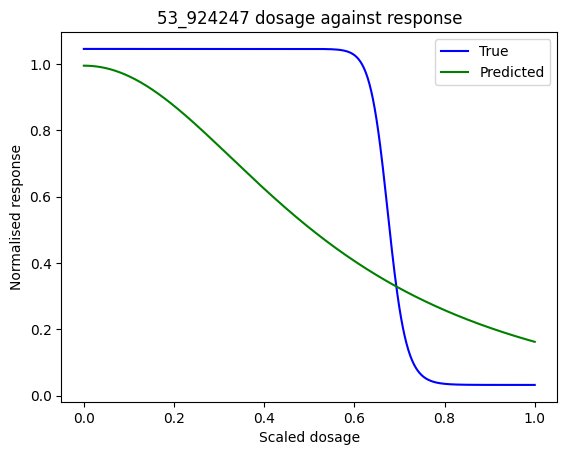

[-4.53409017  0.95595145  4.72002381  0.12327541]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


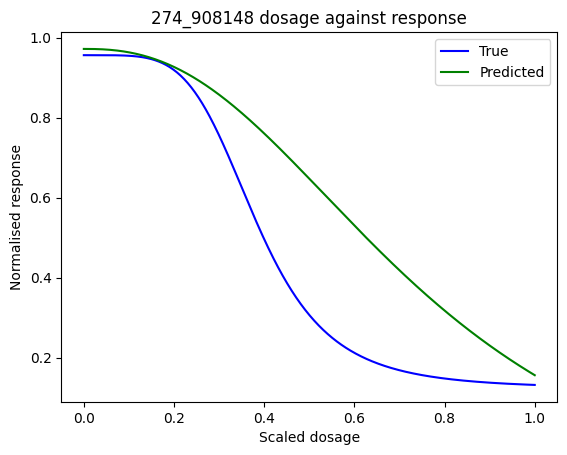

C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


[-5.34538640e+00  1.02684020e+00  8.49416394e+00  5.17851300e-03]


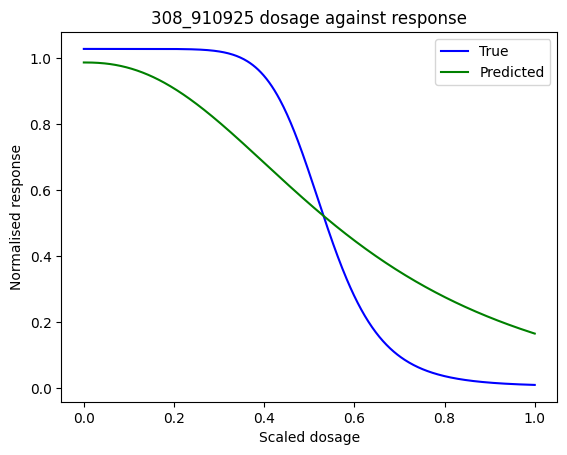

[-4.17607878  0.99994977 12.3584268   0.01496773]


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\944220063.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)


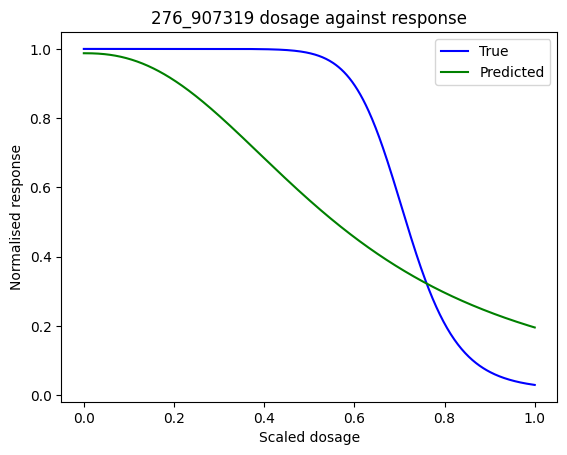

In [88]:
max_int = len(predictedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)

for index in rand_int:
    showTestPredResponses(predictedOptimal.iloc[index]['DRUG_COSMICID'])

In [100]:
# Function to calculate the logistic regression
def ll4_R(x, c, a, b, d):
    return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)

# Load the datasets
boostingTuned = pd.read_csv(_FOLDER_5 + "boostingPredictedTuned.csv")
trueResults = pd.read_csv(_FOLDER_5 + "true_results.csv")
params = ['param_1', 'param_2', 'param_3', 'param_4']

# Initialize a list to store R2 scores
r2_scores = []
r2_scores_with_ids = []

# Iterate over each DRUG_COSMICID in trueResults
for ind, row in trueResults.iterrows():
    cosmicId = row['DRUG_COSMICID']
    trueParams = np.array(row[params])
    predParamsRow = boostingTuned[boostingTuned['DRUG_COSMICID'] == cosmicId]
    if not predParamsRow.empty:
        predParams = np.array(predParamsRow.iloc[0][params])
        xValues = np.linspace(0.0, 1.0, 100)
        trueYcalc = ll4_R(xValues, *trueParams)
        predYcalc = ll4_R(xValues, *predParams)
        r2Score = r2_score(trueYcalc, predYcalc)
        r2_scores.append(r2Score)
        r2_scores_with_ids.append((cosmicId, r2Score))


# Calculate and print the average R2 score
average_r2_score = sum(r2_scores) / len(r2_scores) if r2_scores else 0
median_r2 = np.median(r2_scores)

df_r2_scores = pd.DataFrame(r2_scores_with_ids, columns=['DRUG_COSMICID', 'R2_Score'])


C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\2111054525.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\2111054525.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\2111054525.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\2111054525.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\2111054525.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp(b * np.log(x) - c)) + d)
C:\Users\Asad\AppData\Local\Temp\ipykernel_28180\2111054525.py:3: RuntimeWarning: divide by zero encountered in log
  return ((a-d) / (1 + np.exp

In [102]:
print(f"Average R2 score for Boosting Predicted Tuned: {average_r2_score}")
print(r2_scores)
print(f"Median R²: {median_r2}")

counts = {
    '>0.9': 0,
    '0.8-0.9': 0,
    '0.7-0.8': 0,
    '0.6-0.7': 0,
    '0.5-0.6': 0,
    '0.4-0.5': 0,
    '0.3-0.4': 0,
    '0.2-0.3': 0,
    '0.1-0.2': 0,
    '0-0.1': 0,
    '<0': 0
}

# Iterate over R² scores and increment the corresponding counter
for score in r2_scores:
    if score > 0.9:
        counts['>0.9'] += 1
    elif 0.8 < score <= 0.9:
        counts['0.8-0.9'] += 1
    elif 0.7 < score <= 0.8:
        counts['0.7-0.8'] += 1
    elif 0.6 < score <= 0.7:
        counts['0.6-0.7'] += 1
    elif 0.5 < score <= 0.6:
        counts['0.5-0.6'] += 1
    elif 0.4 < score <= 0.5:
        counts['0.4-0.5'] += 1
    elif 0.3 < score <= 0.4:
        counts['0.3-0.4'] += 1
    elif 0.2 < score <= 0.3:
        counts['0.2-0.3'] += 1
    elif 0.1 < score <= 0.2:
        counts['0.1-0.2'] += 1
    elif 0 < score <= 0.1:
        counts['0-0.1'] += 1
    else:  # score < 0
        counts['<0'] += 1

# Print counts
for category, count in counts.items():
    print(f"R² {category}: {count} scores")



Average R2 score for Boosting Predicted Tuned: 0.6641215296196585
[0.830236779800147, 0.9056483126236063, 0.8355950771676297, 0.8340681889038443, 0.8030888998505922, 0.3535888522148968, -0.2530632251684859, 0.8273099363413207, 0.8048995745379113, 0.7445112765350395, 0.8691799328585323, 0.874865863918531, 0.31928958441375166, 0.7765101087217516, 0.8655060894419062, 0.8891194819933596, 0.0473453310287677, 0.8570680637189665, 0.8166166703903345, 0.7161996686250067, 0.07027691028808081, 0.6644903371310031, 0.8045934045898113, 0.7576202493742825, 0.884080616968081, 0.3207404230962573, 0.7240910699878118, 0.27602195077465075, 0.6521948398099535, 0.8415714198969962, 0.8173212739837632, 0.7584628285875032, 0.7624243320425474, 0.7883438467861774, 0.2752020412088334, 0.8476506012084293, 0.9924222787384996, 0.7320189734835882, 0.6505318536871522, 0.36751231245216553, 0.6882107487557121, 0.8268512116576505, 0.8165950471277378, 0.8887320209129973, -0.10091361949808464, 0.6296360068286898, 0.8470128

In [104]:
print(df_r2_scores)
df_r2_scores.to_csv(_FOLDER_5 + "r2_scores_with_ids.csv", index=False)

    DRUG_COSMICID  R2_Score
0      200_687819  0.830237
1     1012_753594  0.905648
2     1024_905965  0.835595
3    1149_1247871  0.834068
4      173_907280  0.803089
..            ...       ...
495   173_1240153  0.916625
496    157_909262  0.908842
497    272_684055  0.894112
498   104_1330981  0.665090
499    219_910926  0.757332

[500 rows x 2 columns]
